# Barricelli's Game of Life

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Define the simulator

In [2]:
class Barricelli:
    """Barricelli's Game of Life.
    
    Described in detail in this paper:
    
    Barricelli, Nils Aall. Numerical testing of evolution theories. 
        Part I. Theoretical Introduction & Basic Tests. Acta Biotheoretica, vol. 16, nos 1-2, 69–98.
        
    Parameters
    ----------
    world_size : int
        Size of the ecosystem in pixels.
        
    gene_range : int
        Number of possible genes in the ecosystem.
        The same number of them (half) will be positive and  negative.
        Thus, the range of genes will be [-(gene_range // 2), gene_range // 2].
        
    propagation_rule : function
        A function which describes the propagation rule. It should take an index and a numpy array representing
        the current state as arguments and return the contribution of the gene at that index to the next generation, 
        in the form of a tuple of 2 lists of the same length containing indices in the first and values in the second.
        
    collision_rule : function
        A function which describes the collision rule. It should take a list of collisions and a numpy array 
        representing the current state and return the result of the collision in the next generation, as a single
        value to populate the cell in the next generation.
        
    init_time_steps : int, optional
        Number of time steps to allocate space for in history initially.
        Default is 1024.
        
    init_state : array, shape (world_size), optional
        Initial state of genes in the ecosystem.
        If None, initialization will be randomized to values in the range [-1, 1], inclusively.
        Default is None.
        
    init_range : array-like, shape (2), optional
        Range of values to use when randomly initializing, inclusively.
        Ignored if init_state is not None.
        Default is [-1, 1].
        
        
    """
    def __init__(self, world_size, gene_range, propagation_rule, collision_rule, init_time_steps=1024, init_state=None, init_range=(-1, 1)):
        self.world_size = world_size
        if gene_range % 2 == 0:
            self.gene_range = gene_range + 1
        else:
            self.gene_range = gene_range
        self.gene_min = -(gene_range // 2)
        self.gene_max = gene_range // 2
        self.propagation_rule = propagation_rule
        self.collision_rule = collision_rule
        self.history = np.zeros((init_time_steps, world_size), dtype=int)
        if init_state is None:
            self.history[0] = np.random.randint(low=init_range[0], high=init_range[1]+1, size=512)
        else:
            self.history[0] = init_state
        self.init_state = self.history[0].view()
        self.time_step = 0
        self.time_step_jump = init_time_steps
        
    def evolve(self, n_time_steps=1):
        """Simulate evolution of the ecosystem from the current state.
        
        Parameters
        ----------
        n_time_steps : int, optional
            The number of steps to progress.
            Default is 1.
            
        """
        current_state = self.history[self.time_step].copy()
        for i in range(n_time_steps):
            collision_table = [[] for j in range(self.world_size)]
            for j in range(self.world_size):
                indices, values = self.propagation_rule(j, current_state)
                for idx, val in zip(indices, values):
                    if val != 0 and idx < self.world_size and idx >= 0:
                        collision_table[idx] += [val]
            for j in range(self.world_size):
                current_state[j] = (self.collision_rule(np.array(collision_table[j]), j, current_state) - self.gene_min) % self.gene_range + self.gene_min
                
            self.time_step += 1
            if self.time_step == self.history.shape[0]:
                self.history.resize((self.time_step + self.time_step_jump, self.world_size), refcheck=False)
            self.history[self.time_step] = current_state
            
    def current_state(self):
        return self.history[self.time_step]

## Define propagation and collision rules ("norms")

In [3]:
def self_replicating_numbers(index, state):
    value = state[index]
    return [index, (index + value)], [value, value]

def simple_symbiosis(index, state):
    value = state[index]
    child_index = (index + value)
    if child_index < len(state) and child_index >= 0:
        parent_value = state[child_index]
        indices = [child_index]
        values = [value]
        if parent_value != 0 and index + parent_value < len(state) and index + parent_value >= 0:
            indices += [(index + parent_value)]
            values += [value]
    else:
        indices = []
        values = []
    return indices, values

def simple_collision(inputs, index, state):
    return np.sum(inputs) - (len(inputs) - 1) * state[index]

def no_mutation(inputs, index, state):
    if len(inputs) > 0:
        for num1, num2 in zip(inputs[:-1], inputs[1:]):
            if num1 != num2:
                value = 0
                break
        else:
            value = inputs[0]
    else:
        value = 0
    return value
    
def random_mutation(inputs, index, state):
    if len(inputs) == 1:
        value = inputs[0]
    elif len(inputs) >= 2:
        for num1, num2 in zip(inputs[:-1], inputs[1:]):
            if num1 != num2:
                mutate = True
                break
        else:
            mutate = False
            
        if mutate:
            value = np.random.randint(-4, 5)
        else:
            value = inputs[0]
    else:
        value = 0
            
    return value
    
def simple_mutation(inputs, index, state):
    if len(inputs) == 1:
        value = inputs[0]
    elif len(inputs) >= 2:
        for num1, num2 in zip(inputs[:-1], inputs[1:]):
            if num1 != num2:
                mutate = True
                break
        else:
            mutate = False
            
        if mutate:
            no_neighbor = False
            i = index
            dl = 0
            while not no_neighbor and state[i] == 0:
                i -= 1
                dl += 1
                if i < 0:
                    no_neighbor = True
            j = index
            dr = 0
            while not no_neighbor and state[j] == 0:
                j += 1
                dr += 1
                if j >= len(state):
                    no_neighbor = True
            if no_neighbor:
                value = 0
            elif state[i] * state[j] < 0:
                value = - dr - dl
            else:
                value = dr + dl
        else:
            value = inputs[0]

    else:
        value = 0
            
    return value

def split_mutation(inputs, index, state):
    if index < 5 * len(state) // 8 and index > 3 * len(state) // 8:
        return random_mutation(inputs, index, state)
    else:
        return simple_mutation(inputs, index, state)

## Initialize the simulator

In [4]:
init_state = np.array([0, 0, 0, 0, 2, 0, 0, -3] * 48 + [4, 0, 0, 0, -3, 0, 0, 0] * 16)
world_size = 512
gene_range = 17
propagation_rule = simple_symbiosis
collision_rule = simple_mutation
init_time_steps = 512

bc = Barricelli(world_size, gene_range, propagation_rule, collision_rule, init_time_steps, init_state)

## Advance the simulator 512 generations

In [5]:
bc.evolve(n_time_steps=init_time_steps-1)

## Visualize

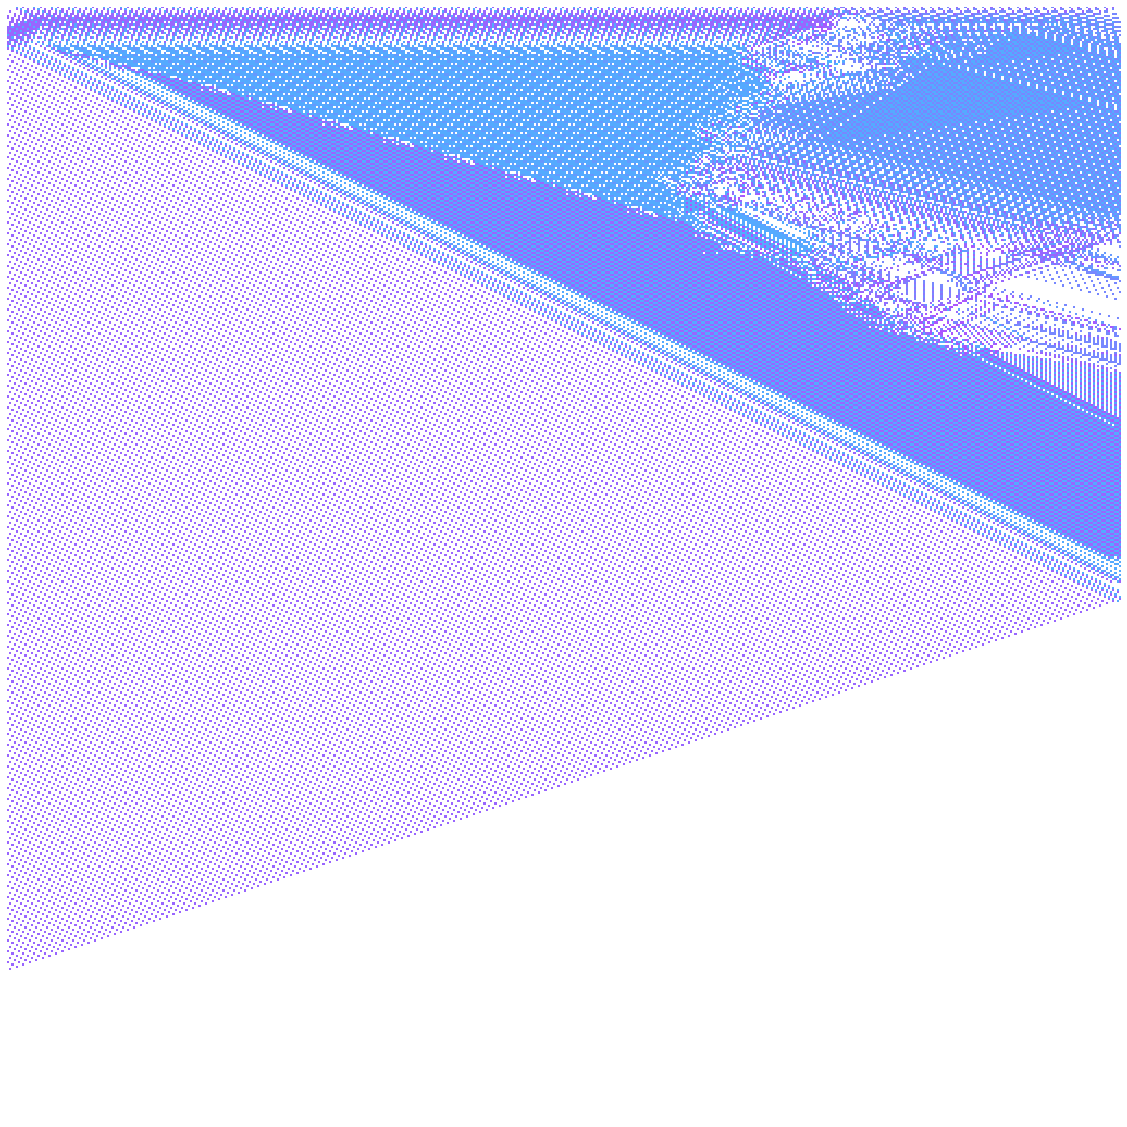

In [6]:
cmap = np.zeros((bc.gene_range, 4))
cmap[:bc.gene_max, :] = plt.cm.cool(np.linspace(0, 1, bc.gene_max * 2))[(bc.gene_max // 2):3*(bc.gene_max // 2), :]
cmap[(bc.gene_max + 1):, :] = plt.cm.cool(np.linspace(0, 1, bc.gene_max * 2))[(bc.gene_max // 2):3*(bc.gene_max // 2), :]
history_image = np.zeros(bc.history.shape + tuple([4]))
for i, j in enumerate(range(bc.gene_min, bc.gene_max)):
    history_image[bc.history == j, :] = cmap[i, :]
    
fig, ax = plt.subplots(1, 1, figsize=(20.48, 20.48))
ax.imshow(history_image)
ax.set_aspect(1.0)
ax.set_axis_off()


## Random initialization

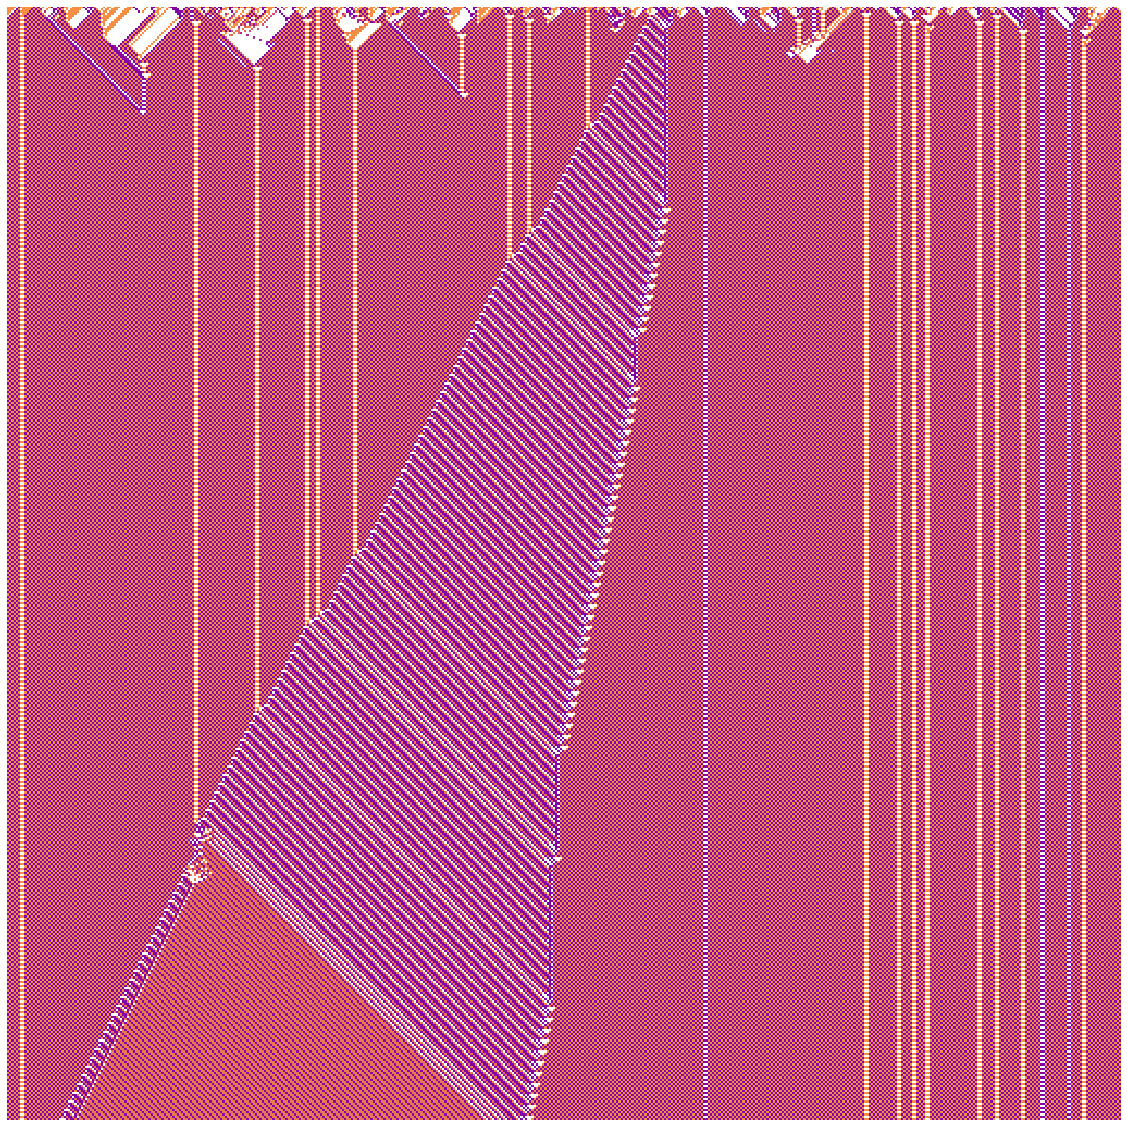

In [7]:
world_size = 512
gene_range = 17
propagation_rule = simple_symbiosis
collision_rule = simple_mutation
init_time_steps = 512
init_range = (-1, 1)

bc = Barricelli(world_size, gene_range, propagation_rule, collision_rule, init_time_steps, init_range=init_range)

bc.evolve(n_time_steps=init_time_steps-1)

cmap = np.zeros((bc.gene_range, 4))
cmap[:bc.gene_max, :] = plt.cm.plasma(np.linspace(0, 1, bc.gene_max * 2))[(bc.gene_max // 2):3*(bc.gene_max // 2), :]
cmap[(bc.gene_max + 1):, :] = plt.cm.plasma(np.linspace(0, 1, bc.gene_max * 2))[(bc.gene_max // 2):3*(bc.gene_max // 2), :]
history_image = np.zeros(bc.history.shape + tuple([4]))
for i, j in enumerate(range(bc.gene_min, bc.gene_max)):
    history_image[bc.history == j, :] = cmap[i, :]
    
fig, ax = plt.subplots(1, 1, figsize=(20.48, 20.48))
ax.imshow(history_image)
ax.set_aspect(1.0)
ax.set_axis_off()